In [77]:
import numpy as np

import adaptive_latents
from adaptive_latents import (
    AnimationManager, 
    Pipeline, 
    CenteringTransformer, 
    proSVD, 
    Bubblewrap, 
    VanillaOnlineRegressor, 
    NumpyTimedDataSource, 
    KernelSmoother, 
    Concatenator, 
    sjPCA, 
    ZScoringTransformer, 
    mmICA
)
import adaptive_latents.input_sources.datasets as datasets
import adaptive_latents.plotting_functions as pf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from adaptive_latents.timed_data_source import ArrayWithTime
from IPython.display import Video, Image, display

from importlib import reload
import socket
hostname = socket.gethostname()
rng = np.random.default_rng()



In [78]:
!echo $(hostname) $(git rev-parse --short HEAD)

/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


tycho bc668fd



## Prediction tables


In [79]:
# %%time
%matplotlib inline
shortrun = hostname == 'tycho' and True


d = datasets.Odoherty21Dataset(neural_lag=0, pos_rescale_factor=1/30, vel_rescale_factor=1/75)

"""

0: [neural_data] -> center -> smooth -> concat[0] -> 2
1: [behavior] -> Zscore -> concat[1] -> 2
2: prosvd -> jpca -> bubblewrap -> regression1['x']
3: [behavior] -> regression1['y']
4: [neural_data] -> center -> smooth -> prosvd -> regression2['y']
5: joints
"""

streams = []
streams.append((d.neural_data, 0))
streams.append((d.beh_pos, 1))
# 2 is reserved for the post-concatination pipeline
streams.append((d.beh_pos, 3))
streams.append((d.neural_data, 4))
# 5 for the alpha to joint

# this pipeline makes the latent space
p1 = Pipeline([
    CenteringTransformer(init_size=100, input_streams={0:'X'}, output_streams={0:0}),
    KernelSmoother(tau=0.04/d.bin_width, input_streams={0:'X'}, output_streams={0:0}),
    # zst:=ZScoringTransformer(init_size=10/d.beh_pos.dt, freeze_after_init=False, input_streams={1:'X'}, output_streams={1:1}),
    Concatenator(input_streams={0: 0, 1: 1}, output_streams={0:2, 1:2, 'skip':-1}),
])

pro=proSVD(k=6, init_size=100, input_streams={2:'X'}, output_streams={2:2})
jpca=sjPCA(init_size=100, input_streams={2:'X'}, output_streams={2:2})
ica=mmICA(init_size=100, input_streams={2:'X'}, output_streams={2:2})


latents_for_bw = ['prosvd', 'jpca', 'mmica'][1]
pre_bw_latent_dims_to_drop = 0


# this pipeline handles the prediction and regression
bw = Bubblewrap(
    num=1100,
    M=500,
    lam=1e-3,
    nu=1e-3,
    eps=1e-4,
    step=1,
    num_grad_q=1,
    sigma_orig_adjustment=100, # 0
    input_streams={2:'X'},
    output_streams={2:2},
    log_level=1,
)

alpha_to_beh_reg = VanillaOnlineRegressor(
    input_streams={2:'X', 3:'Y'},
)

neural_only_reg_pipeline = Pipeline([
    CenteringTransformer(**(p1.steps[0].get_params() | dict(input_streams={4:'X'}, output_streams={4:4}))),
    KernelSmoother(**(p1.steps[1].get_params() | dict(input_streams={4:'X'}, output_streams={4:4}))),
    proSVD(k=4, init_size=100, input_streams={4:'X'}, output_streams={4:4}),
    alpha_to_neural_reg:=VanillaOnlineRegressor(
        input_streams={2:'X', 4:'Y'},
    )
    
], 
reroute_inputs=False
)

alpha_to_joint_latents_reg = VanillaOnlineRegressor(
    input_streams={2:'X', 5:'Y'},
)


exit_time = 40 if shortrun else 600

pbar = tqdm(total=exit_time)
pro_latents = []
jpca_latents = []
ica_latents = []

next_bubble_predictions = []
beh_predictions = []
neural_predictions = []
joint_predictions = []

beh_target = []
neural_target = []
joint_target = []


for output, stream in p1.streaming_run_on(streams, return_output_stream=True):
    # prosvd step
    pro_output, pro_stream = pro.partial_fit_transform(output, stream, return_output_stream=True)
    if pro_stream == 2 and np.isfinite(pro_output).all():
        pro_latents.append(pro_output)

    # sjpca step
    jpca_output, jpca_stream = jpca.partial_fit_transform(pro_output, pro_stream, return_output_stream=True)
    if jpca_stream == 2 and np.isfinite(jpca_output).all():
        jpca_latents.append(jpca_output)

    # ica step (not in main line)
    ica_output, ica_stream = ica.partial_fit_transform(pro_output, pro_stream, return_output_stream=True)
    if ica_stream == 2 and np.isfinite(ica_output).all():
        ica_latents.append(ica_output)

    # bw step
    pre_bw_output, pre_bw_stream = {
        'prosvd': (pro_output, pro_stream),
        'jpca': (jpca_output, jpca_stream),
        'mmica': (ica_output, ica_stream),
    }[latents_for_bw] 
    
    if pre_bw_stream == 2 and pre_bw_latent_dims_to_drop > 0:
        pre_bw_output = pre_bw_output[:,:-pre_bw_latent_dims_to_drop]
    
    output, stream = bw.partial_fit_transform(pre_bw_output, pre_bw_stream, return_output_stream=True)

    # fit all the regressions on alpha
    alpha_to_beh_reg.partial_fit_transform(output, stream)
    neural_stream_output, neural_stream_stream = neural_only_reg_pipeline.partial_fit_transform(output, stream, return_output_stream=True)
    
    alpha_to_joint_latents_reg.partial_fit_transform(output, stream)
    alpha_to_joint_latents_reg.partial_fit_transform(pre_bw_output, 5 if pre_bw_stream == 2 else pre_bw_stream)
    
    if stream == 3:
        beh_target.append(output)
        
    if neural_stream_stream == 4 and not np.isnan(neural_stream_output).any():
        neural_target.append(neural_stream_output)
        
    if pre_bw_stream == 2 and np.isfinite(pre_bw_output).all():
        joint_target.append(pre_bw_output)
    
    if stream == 2 and np.isfinite(output).all(): # do predictions
        prediction_t = output.t + bw.dt

        # alpha_pred = bw.get_alpha_at_t(0, relative_t=True)

        alpha_pred = bw.get_alpha_at_t(prediction_t)

        # alpha_pred[np.argmax(bw.alpha)] = 0
        # alpha_pred[alpha_pred < alpha_pred.max()] = 0
        # alpha_pred = alpha_pred / alpha_pred.sum()


        next_bubble_predictions.append(ArrayWithTime(bw.mu[np.argmax(alpha_pred)], t=prediction_t))
        
        beh_predictions.append(ArrayWithTime(alpha_to_beh_reg.predict(alpha_pred), t=prediction_t))
        neural_predictions.append(ArrayWithTime(alpha_to_neural_reg.predict(alpha_pred), t=prediction_t))
        joint_predictions.append(ArrayWithTime(alpha_to_joint_latents_reg.predict(alpha_pred), t=prediction_t))

    if output.t >= exit_time:
        break

    pbar.update(round(output.t,1) - pbar.n)


pro_latents = ArrayWithTime.from_list(pro_latents)
jpca_latents = ArrayWithTime.from_list(jpca_latents)
ica_latents = ArrayWithTime.from_list(ica_latents)

next_bubble_predictions = ArrayWithTime.from_list(next_bubble_predictions)

beh_predictions = ArrayWithTime.from_list(beh_predictions)
neural_predictions = ArrayWithTime.from_list(neural_predictions)
joint_predictions = ArrayWithTime.from_list(joint_predictions)


beh_target = ArrayWithTime.from_list(beh_target)
neural_target = ArrayWithTime.from_list(neural_target)
joint_target = ArrayWithTime.from_list(joint_target)



/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


  0%|          | 0/40 [00:00<?, ?it/s]

Text(0.5, 1.0, 'alpha')

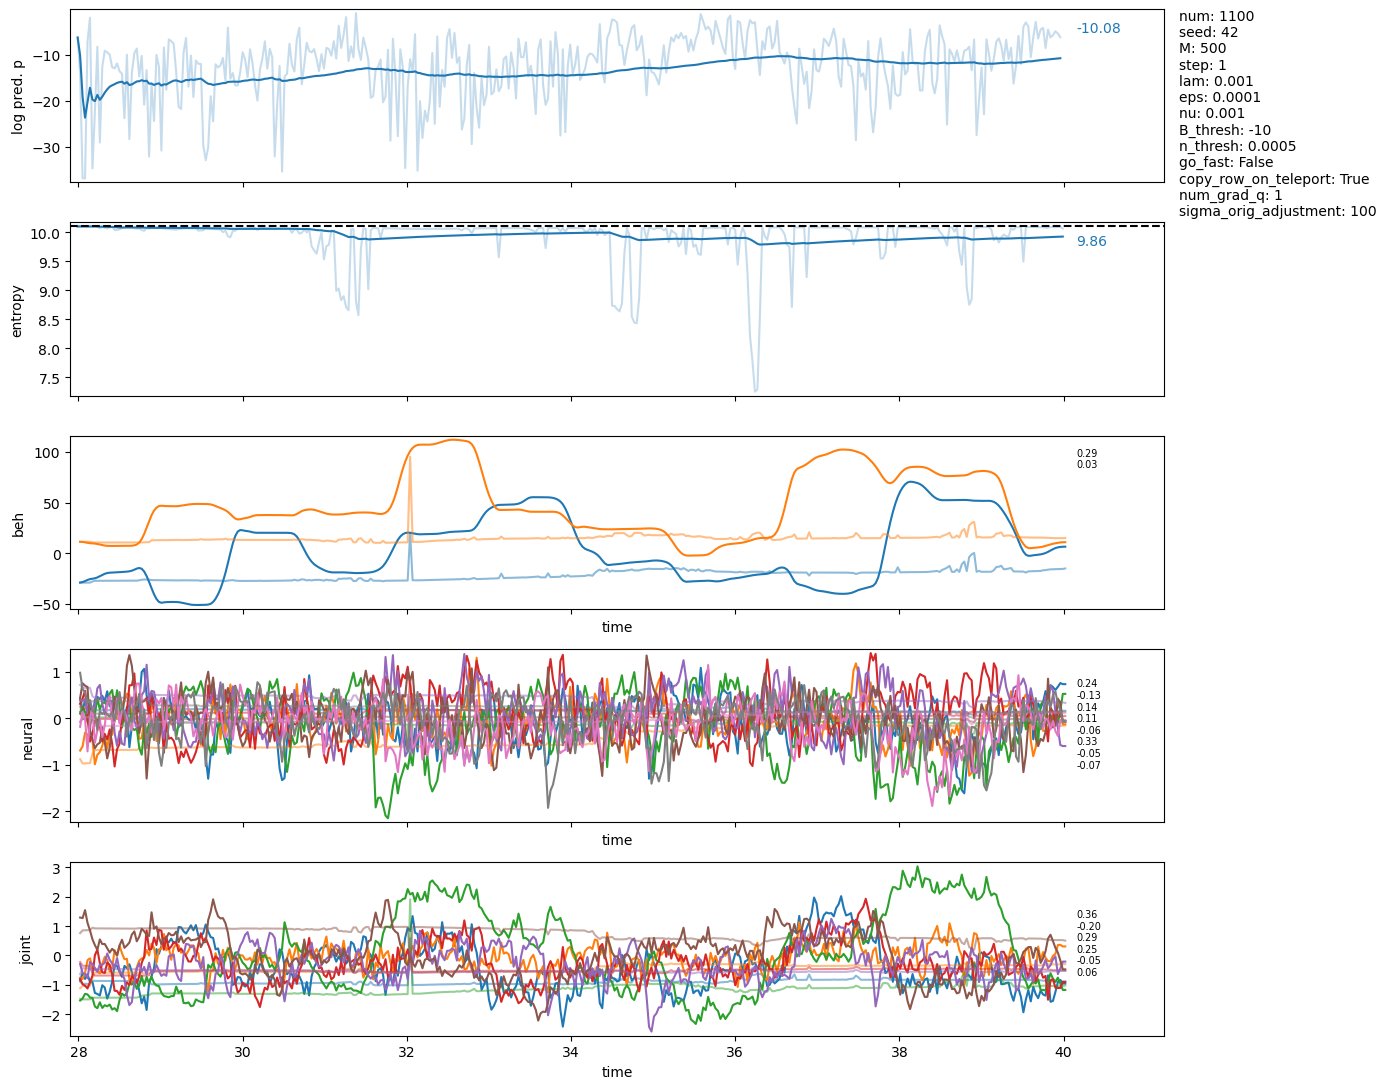

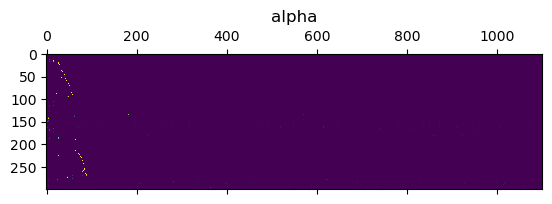

In [80]:
%matplotlib inline
behavior_dicts = [
    dict(
        true_behavior=beh_target,
        true_behavior_t=beh_target.t,
        predicted_behavior=beh_predictions,
        predicted_behavior_t=beh_predictions.t,
        label='beh'
    ),
    dict(
        true_behavior=neural_target,
        true_behavior_t=neural_target.t,
        predicted_behavior=neural_predictions,
        predicted_behavior_t=neural_predictions.t,
        label='neural'
    ),
    dict(
        true_behavior=joint_target,
        true_behavior_t=joint_target.t,
        predicted_behavior=joint_predictions,
        predicted_behavior_t=joint_predictions.t,
        label='joint'
    ),
    ]
adaptive_latents.plotting_functions = reload(adaptive_latents.plotting_functions)
adaptive_latents.plotting_functions.plot_bw_pipeline([bw], behavior_dicts)

fig, ax = plt.subplots()
ax.matshow(bw.log['alpha'][-300:])
ax.set_title('alpha')

Text(0, 0.5, 'ica')

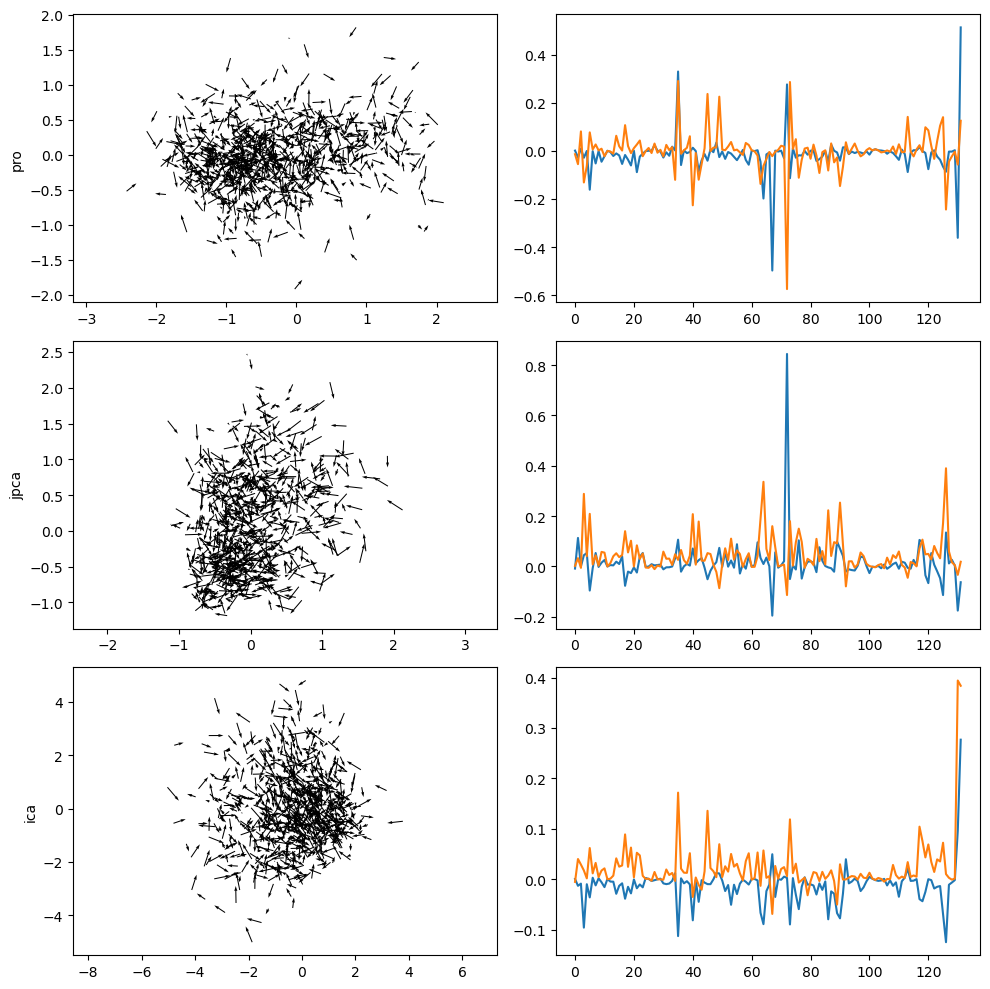

In [81]:
%matplotlib inline
fig, axs = plt.subplots(nrows=3, ncols=2, squeeze=False, layout='tight', figsize=(10,10))


for idx, latents in enumerate([pro_latents, jpca_latents, ica_latents]):
    ax = axs[idx, 0]
    # ax.scatter(latents[:,0], latents[:,1], s=5)

    d_latents = np.diff(latents, axis=0)
    d_latents = d_latents / np.linalg.norm(d_latents, axis=1)[:, np.newaxis]
    ax.quiver(latents[:-1, 0], latents[:-1, 1], d_latents[:, 0], d_latents[:, 1], scale=1 / 20, units='dots')
    x1, x2, y1, y2 = ax.axis()
    x_points = np.linspace(x1, x2, 10)
    y_points = np.linspace(y1, y2, 10)
    mgrid = np.meshgrid(*[np.linspace(latents[:, i].min(), latents[:, i].max(), 10) for i in range(latents.shape[1])])
    
    ax.axis('equal')

    ax = axs[idx, 1]


e1, e2 = np.zeros(6), np.zeros(6)
e1[0] = 1
e2[1] = 1

axs[0,1].plot(pro.inverse_transform(e1, 2))
axs[0,1].plot(pro.inverse_transform(e2, 2))
axs[0,0].set_ylabel('pro')

axs[1,1].plot(pro.inverse_transform(jpca.inverse_transform(e1, 2), 2))
axs[1,1].plot(pro.inverse_transform(jpca.inverse_transform(e2, 2), 2))
axs[1,0].set_ylabel('jpca')

axs[2,1].plot(pro.inverse_transform(ica.inverse_transform(e1, 2), 2))
axs[2,1].plot(pro.inverse_transform(ica.inverse_transform(e2, 2), 2))
axs[2,0].set_ylabel('ica')



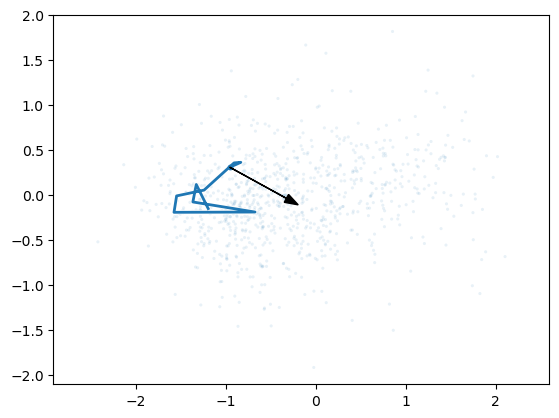

In [82]:
fig, ax = plt.subplots()

latents = pro_latents

dim_1, dim_2 = 0,1
pf.plot_history_with_tail(ax, latents, dim_1=dim_1, dim_2=dim_2)
means = np.mean(latents, axis=0)

ax.arrow(latents[-1,dim_1], latents[-1,dim_2], means[dim_1] - latents[-1,dim_1], means[dim_2] - latents[-1,dim_2], zorder=5, head_width=.1, color='k')

ax.axis('equal');



In [84]:
assert isinstance(d, datasets.Zong22Dataset)
desired_pattern = np.mean(latents[-101:-1], axis=0)
current_pattern = latents[-1]
desired_stim = desired_pattern - current_pattern

desired_pattern = (desired_stim @ pro.Q.T)[:d.neural_data.a.shape[-1]]

near_zero = np.abs(desired_stim) < 100
print(near_zero.sum())
desired_stim[near_zero] = np.nan


fig, ax = plt.subplots()
d.show_stim_pattern(ax, np.abs(desired_pattern))


AssertionError: 

## Intro video

In [ ]:
d = datasets.Odoherty21Dataset()

tail_length = 5  # seconds

with AnimationManager(n_cols=2, n_rows=1, figsize=(10, 5)) as am:
    for current_t in np.linspace(100, 110, 51):
        am.axs[0,0].cla()

        n_columns = np.floor(tail_length / d.bin_width).astype(int)
        idx = np.nonzero(~(d.neural_data.t < current_t))[0][0]
        
        
        am.axs[0,0].imshow(d.neural_data.a[idx-n_columns:idx,0,:].T, aspect='auto', interpolation='none', extent=[current_t - tail_length, current_t, d.neural_data.a.shape[2], 0])



        old_lims = am.axs[0,1].axis()
        am.axs[0,1].cla()
        am.axs[0,1].axis('off')
        
        s = ((current_t - tail_length) < d.behavioral_data.t) & (d.behavioral_data.t < current_t)
        am.axs[0,1].plot(d.behavioral_data.a[s,0,0], d.behavioral_data.a[s,0,1])
        pf.use_bigger_lims(am.axs[0,1], old_lims)
        
        am.grab_frame()